# 1) Introduction: Computational Geometry and scipy.spatial

In [981]:
import scipy
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import scipy.optimize
import PIL
import matplotlib
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.collections import PolyCollection
from matplotlib.collections import PatchCollection
from matplotlib import colors
import pickle
import circumcircle
%matplotlib inline
scipy.__version__

'0.19.0'

# 2) Distances between arrays of points

## 2.1) scipy.spatial.distance_matrix

### 2.1.1) Euclidean (L2 norm)

There are many cases where it is desirable to calculate the distances between all possible pairs of points from two data sets. Consider a self-driving vehicle that is programmed to avoid animals that enter a roadway. It may have a set of coordinates that represent the vehicle proper relative to some kind of camera / detector, and another set of coordinates that represent the apparent obstruction (animal on the road).

For simplicity, lets define the two sets of coordinates randomly:

In [982]:
vehicle_coords = np.random.random((50,3))
animal_coords = np.random.random((600,3))

In order to calculate the amount of time that the vehicle has to make a course adjustment, it would be sensible to first calculate the closest distance between a point on the vehicle and a point on the animal. Lets try this by calculating all possible distances between the objects and finding the minimum of that distance matrix.

In [983]:
from scipy.spatial import distance_matrix
all_distances = distance_matrix(vehicle_coords, animal_coords)
all_distances.shape

(50, 600)

Each row of the distance matrix represents a point on the vehicle, and each column (value in a given row) is the distance between that point on the vehicle and one of the points on the animal (ordered by index).

In [984]:
closest_distance = all_distances.min()
closest_distance

0.027845995724528557

### 2.1.2) Rectilinear (L1 norm)

Consider another situation, where a self-driving vehicle is aware (i.e., via real-time 'traffic' reporting) of an animal obstructing a roadway, even though the vehicle does not have line of sight to the animal obstacle. The animal is a few city blocks away, but the vehicle would still benefit from a distance & time estimate so that appropriate adjustments may be made. 

In this case, the straight-line Euclidean distance would not represent the shortest distance the vehicle would travel in practice--instead, we need to consider the so-called L1 norm / taxicab geometry/ Manhattan distance, etc. 

In [985]:
taxicab_distances = distance_matrix(vehicle_coords, animal_coords, p=1)
taxicab_distances.shape

(50, 600)

In [986]:
closest_taxicab_distance = taxicab_distances.min()
closest_taxicab_distance

0.033077202000236228

## 2.2) scipy.spatial.distance.cdist

### 2.2.1) Faster than distance_matrix for Euclidean norm

In [987]:
%timeit distance_matrix(vehicle_coords, animal_coords)

1000 loops, best of 3: 1.65 ms per loop


In [988]:
from scipy.spatial.distance import cdist

In [989]:
%timeit cdist(vehicle_coords, animal_coords)

1000 loops, best of 3: 361 µs per loop


In [990]:
# confirm same value for p=2 norm
distance_matrix(vehicle_coords, animal_coords, p=2).min() == cdist(vehicle_coords, animal_coords, metric='euclidean').min()

True

### 2.2.2) Faster than distance_matrix for L1 norm

In [991]:
%timeit distance_matrix(vehicle_coords, animal_coords, p=1)

1000 loops, best of 3: 1.41 ms per loop


Slower with minkowski metric specification though!

In [992]:
%timeit cdist(vehicle_coords, animal_coords, metric='minkowski', p=1)

100 loops, best of 3: 5.23 ms per loop


Use cityblock metric instead of p=1 minkowski

In [993]:
# time equivalent calculation using alternative calling convention
%timeit cdist(vehicle_coords, animal_coords, metric='cityblock')

10000 loops, best of 3: 168 µs per loop


Make sure the two different rectilinear calling conventions produce the same value

In [994]:
cdist(vehicle_coords, animal_coords, metric='minkowski', p=1).min() == cdist(vehicle_coords, animal_coords, metric='cityblock').min()

True

And likewise for cdist vs. distance_matrix for rectilinear distance

In [995]:
# confirm same value for p=1 norm
distance_matrix(vehicle_coords, animal_coords, p=1).min() == cdist(vehicle_coords, animal_coords, metric='minkowski', p=1).min()

True

### 2.2.3) Using cdist for Mahalanobis distance -- clustering and outlier detection

Apart from the enhanced performance (at least for the data shapes tested above) of `cdist` over `distance_matrix`, `cdist` also has access to a wide variety of distance metrics with a plethora of possible applications.

Consider the following ellipsoidal and circular data sets:

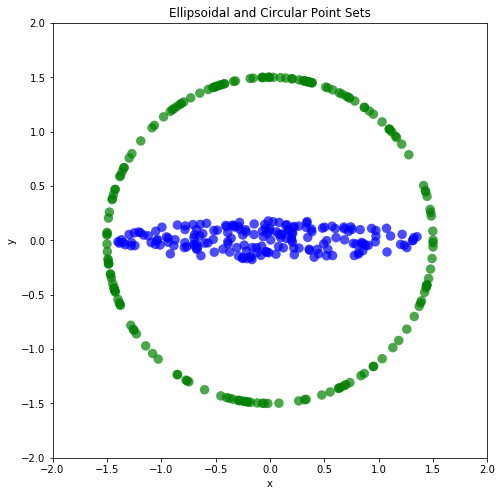

In [996]:
# ellipsoidal point set generation: http://stackoverflow.com/a/5529199/2942522
np.random.seed(255792)
width = 2.82
height = 0.36
phi = np.random.random((180)) * 2 * math.pi 
rho = np.random.random((180))
x_ellipse = np.sqrt(rho) * np.cos(phi)
y_ellipse = np.sqrt(rho) * np.sin(phi)
x_ellipse *= width / 2.0
y_ellipse *= height / 2.0
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_ellipse, y_ellipse, c='blue', alpha=0.7, edgecolor='none', s=90)
ax.set_title('Ellipsoidal and Circular Point Sets')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
circle_radius = 1.5
x_circle = np.cos(phi) * circle_radius
y_circle = np.sin(phi) * circle_radius
ax.scatter(x_circle, y_circle, c='green', alpha=0.7, edgecolor='none', s=90)

fig.set_size_inches(8,8)

The Mahalanobis distance for each circular point (relative to the elliptical point set) will account for the "shape" of the ellipse and not just the mean of the elliptical points.



In [997]:
np.dstack((x_ellipse, y_ellipse))[0].shape

(180, 2)

In [998]:
mahalanobis_distances = cdist(np.dstack((x_ellipse, y_ellipse))[0],
                              np.dstack((x_circle, y_circle))[0],
                              metric='mahalanobis')
mahalanobis_distances.shape

(180, 180)

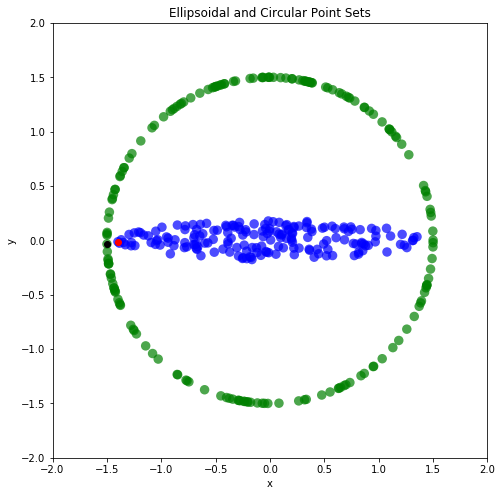

In [999]:
ellipse_index, circle_index = np.where(mahalanobis_distances == mahalanobis_distances.min())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x_ellipse, y_ellipse, c='blue', alpha=0.7, edgecolor='none', s=90)
ax.set_title('Ellipsoidal and Circular Point Sets')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.scatter(x_circle, y_circle, c='green', alpha=0.7, edgecolor='none', s=90)
ax.scatter(x_ellipse[ellipse_index], y_ellipse[ellipse_index], c = 'red')
ax.scatter(x_circle[circle_index], y_circle[circle_index], c = 'k')
fig.set_size_inches(8,8)

## 2.3) scipy.spatial.distance.pdist

In [1000]:
from scipy.spatial.distance import pdist

### 2.3.1) pdist basics -- very simple example

In [1001]:
test_array = np.array([[0,0],
                       [0,1],
                       [0,2]])

The *condensed* distance matrix returned by `pdist` for the above `test_array` should have three values:

1. Distance between [0,0] and [0,1]
2. Distance between [0,0] and [0,2]
3. Distance between [0,1] and [0,2]

Let's try it:

In [1002]:
condensed_matrix = pdist(test_array)
condensed_matrix

array([ 1.,  2.,  1.])

Although it may be relatively easy to track which distance value corresponds to which pair of points in this case, if `test_array` were much larger, working with a condensed distance matrix may become confusing.

This is where `scipy.spatial.distance.squareform` becomes useful:

In [1003]:
from scipy.spatial.distance import squareform
redundant_matrix = squareform(condensed_matrix)
redundant_matrix

array([[ 0.,  1.,  2.],
       [ 1.,  0.,  1.],
       [ 2.,  1.,  0.]])

Even though `pdist` does not calculate the distance between a point and *itself*, `squareform` converts the condensed distance matrix to the familiar redundant form that would also be returned by `cdist` for the data set compared with *itself*:

In [1004]:
cdist(test_array, test_array)

array([[ 0.,  1.,  2.],
       [ 1.,  0.,  1.],
       [ 2.,  1.,  0.]])

It is worth noting that `squareform` can perform the reverse conversion as well:

In [1005]:
squareform(cdist(test_array, test_array)) # produce the same result as pdist by using squareform

array([ 1.,  2.,  1.])




| <font color='blue'>Development Note</font>| Type of Change | Pull Request # | `scipy` Implementation Version |
|----------------|------------|----------|
| `squareform` no longer converts all input data to `float64` | <font color='green'>Enhancement</font> | 6457 | <font color='purple'>0.19</font> |




### 2.3.2 pdist 'real-world' example

Imagine that you have experimental scientific data for the behavior of a protein (molecule) in the human body that causes a specific medical condition. Your suspicion is that this molecule becomes "compacted" / squished in the disease state. You want to know which two atoms are closest together in the normal vs. diseased state, to assess whether there really is evidence of compaction.

In [1006]:
np.random.seed(387)
normal_coordinates = np.random.random((12000,3))
disease_coordinates = np.random.random((12000,3))

We could try a brute-force approach using `cdist` to compare a data set against itself:

In [1007]:
normal_dist_matrix_cdist = cdist(normal_coordinates, normal_coordinates)
disease_dist_matrix_cdist = cdist(disease_coordinates, disease_coordinates)
print('normal min:', normal_dist_matrix_cdist.min())
print('disease min:', disease_dist_matrix_cdist.min())

normal min: 0.0
disease min: 0.0


We actually need to filter out the self-comparisons when using `cdist` in this manner. To do this, we effectively filter out the diagonal of the square distance matrix before calculating the minimum:

In [1008]:
for name, cdist_array in zip(['normal', 'disease'], [normal_dist_matrix_cdist, disease_dist_matrix_cdist]):
    mask = np.ones(cdist_array.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    print(name, ':', cdist_array[mask].min())


normal : 0.00191693986339
disease : 0.00157908261241


But, as you may have guessed, the redundant square matrices produced by `cdist` can be quite large:

In [1009]:
normal_dist_matrix_cdist.size, disease_dist_matrix_cdist.size

(144000000, 144000000)

It also just *feels* intuitively a bit strange to have to feed the same array of data to `cdist` twice, and this is a strong indicator that `pdist` may be a more efficient choice, especially for a large data set.

In [1010]:
normal_dist_matrix_pdist = pdist(normal_coordinates)
disease_dist_matrix_pdist = pdist(disease_coordinates)
normal_dist_matrix_pdist.size, disease_dist_matrix_pdist.size

(71994000, 71994000)

In [1011]:
normal_dist_matrix_cdist.size / normal_dist_matrix_pdist.size

2.000166680556713

The number of floating point numbers stored by the result of `pdist` is roughly half that stored by the return value of `cdist` in this case. This could make a really big difference when working with 'big data' sets.

Now, confirm that the results from the two approaches are simply transformations of the same data:

In [1012]:
np.testing.assert_equal(squareform(disease_dist_matrix_cdist), disease_dist_matrix_pdist)

# 3) Distances between single numeric vectors

For computing the distances between two 1D arrays `scipy.spatial.distance` has many of the same functions as are available to the `metric` arguments of `pdist` and `cdist`. However, it is important to note that the `metric` for `pdist` and `cdist` should always be specified as the `string` type argument (i.e., "euclidean") to use the optimized C-level implementation instead of providing the built-in 1D vector distance function name (i.e., `scipy.spatial.distance.euclidean`).

Of course, in some cases one may actually wish to calculate the distance between two 1D vectors, for which the specific functions in scipy.spatial.distance are appropriate.

## 3.1) Calculate the Euclidean distance between two arrays

In [1013]:
array_1 = np.random.random((3,))
array_2 = np.random.random((3,))
euclidean_dist = scipy.spatial.distance.euclidean(array_1, array_2)
euclidean_dist

0.4756617846886483

In [1014]:
# but not appropriate for > 1D arrays
array_1 = np.random.random((2, 3))
array_2 = np.random.random((2, 3))
try:
    euclidean_dist = scipy.spatial.distance.euclidean(array_1, array_2)
except ValueError:
    print('ValueError raised')


ValueError raised


## 3.2) Calculate the cityblock distance between two arrays

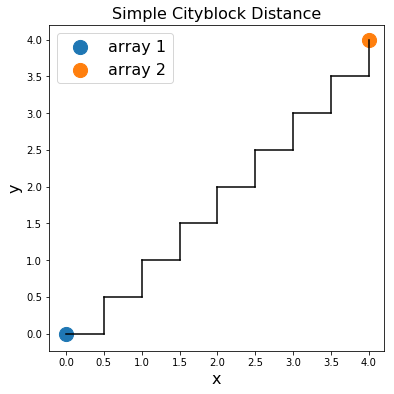

In [1015]:
array_1 = np.zeros((2,))
array_2 = np.array([4, 4])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(array_1[0], array_1[1], s=200, label='array 1')
ax.scatter(array_2[0], array_2[1], s=200, label='array 2')
ax.legend(fontsize=16)
# add 'city blocks / steps' to plot
step_val = 0.5
current_pos = np.zeros((2,))
next_pos = np.zeros((2,))
x_val = 0
x_turn = 1
while x_val < 8:
    if x_turn:
        next_pos[0] += step_val
        x_turn = 0
    else:
        next_pos[1] += step_val
        x_turn = 1
        
    ax.plot([current_pos[0], next_pos[0]], [current_pos[1], next_pos[1]], c='k')
    current_pos[:] = next_pos[:]
    x_val += step_val

ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_title('Simple Cityblock Distance', fontsize=16)
fig.set_size_inches(6,6)

In [1016]:
cityblock_dist = scipy.spatial.distance.cityblock(array_1, array_2)
cityblock_dist

8.0

Note that the City Block distance is equivalent to the sum of the x and y steps, and would be equivalent for one large block (single step).

## 3.3) Calculate the weighted Minkowski distance between two arrays

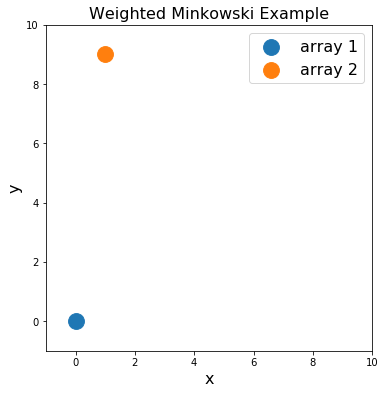

In [1017]:
array_1 = np.zeros((2,))
array_2 = np.array([1,9])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(array_1[0], array_1[1], s=250, label='array 1')
ax.scatter(array_2[0], array_2[1], s=250, label='array 2')
ax.legend(fontsize=16)

ax.set_xlim(-1,10)
ax.set_ylim(-1,10)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.set_aspect('equal')
ax.set_title('Weighted Minkowski Example', fontsize=16)
fig.set_size_inches(6,6)

We could pick any p-norm for this calculation, but for conceptual simplicity let's stick with the Euclidean L2 norm. For the conventional Euclidean distance we would expect `d > 9` by simple visual inspection. 

However, given the small difference in `x` coordinate values, perhaps we can achieve `d < 9` with the appropriate weighting.

In [1018]:
weight_vector = [1, 0]
weighted_euclidean_dist = scipy.spatial.distance.wminkowski(array_1, array_2, p=2, w=weight_vector)
weighted_euclidean_dist

1.0

In [1019]:
weight_vector = [1, 0.1]
weighted_euclidean_dist = scipy.spatial.distance.wminkowski(array_1, array_2, p=2, w=weight_vector)
weighted_euclidean_dist

1.3453624047073711

In [1020]:
weight_vector = [1, 1]
weighted_euclidean_dist = scipy.spatial.distance.wminkowski(array_1, array_2, p=2, w=weight_vector)
print('weighted_euclidean_dist with equal unit weights:', weighted_euclidean_dist)
assert weighted_euclidean_dist == scipy.spatial.distance.euclidean(array_1, array_2)

weighted_euclidean_dist with equal unit weights: 9.055385138137417


The shifting of the weighted distance matches nicely with intuition.

# 4) Distances between single boolean vectors

Once again, the specific 1D boolean distance functions in `scipy.spatial.distance` should only be used for comparison of two 1D vectors, while i.e., `pdist` with the metric `string` argument (i.e., "hamming") should be used for larger boolean comparisons.

## 4.1) Calculate the hamming distance between two 1D arrays

The *Reed-Solomon code* adds extra / redundant data bits to a data storage medium (i.e., CD, DVD, etc.) to assist with error correction. For example, error correction may be possible in the event of a minor scratch on the surface of a CD or if the reading device 'skips.' While the precise implementation details are beyond the scope of this example, if we think of these extra error-correcting bits as "code words," imagine a case where the encoder places a set of extra bits in the storage medium and the recovered equivalent word during decoding differs. We'd like a way to quantify the number of substitutions required to restore the original code word, which is an important metric in error correction.

In [1021]:
original_code_word =  np.array([0, 1, 1, 0, 1, 1, 0, 0], dtype=np.bool)
recovered_code_word = np.array([1, 1, 0, 0, 1, 1, 0, 1], dtype=np.bool)

from scipy.spatial.distance import hamming
minimum_substitutions = hamming(original_code_word, recovered_code_word)
minimum_substitutions

0.375

Why isn't the Hamming distance an integer number corresponding to the number of positions that differ? Because we divide by the total number of "letters" (bits) in each "word" (byte). So, the scipy `hamming` function is really the **normalized** Hamming distance.

In [1022]:
np.argwhere(original_code_word != recovered_code_word).size / original_code_word.size

0.375

Of course, the real-world implementation has more details and more bytes, so one might use i.e., `pdist` with the metric "hamming" argument for larger comparisons of arrays.

## 4.2) Calculate the Jaccard distance between two 1D arrays

Let's say we want to assess the ability of a computer program to identify a penguin in a real photograph based on a set of trial attempts to bound the animal. The photograph was taken by Jack Green with credit to the NSF as well.

![Emporor Penguin; Jack Green / NSF](emperor-penguin-alpha-construction-site-sign.jpg)

In [1023]:
from scipy.spatial.distance import jaccard
from PIL import Image
im = Image.open('emperor-penguin-alpha-construction-site-sign.jpg')
im.size # pixel dimensions

(1524, 1128)

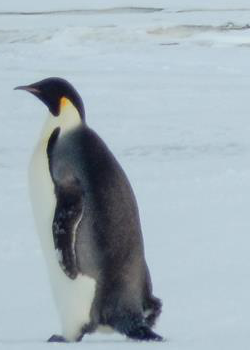

In [1024]:
# define the reference / ground truth bounding box visually
x_start_ref = 350
x_end_ref = 550
y_start_ref = 600
y_end_ref = 900
box_actual = (x_start_ref, x_end_ref, y_start_ref, y_end_ref)
region = im.crop(box_actual)
region

In [1025]:
# define ground truth reference matrix as a 1D boolean array of pixel matches to the original image
def generate_bool_matrix(original_image, x_start, x_end, y_start, y_end):
    matrix = np.zeros(original_image.size)
    matrix[x_start:x_end, y_start:y_end] = 1
    matrix = matrix.astype(np.bool, copy=False).ravel()
    return matrix

reference_matrix = generate_bool_matrix(im, x_start_ref, x_end_ref, y_start_ref, y_end_ref)
# sanity check on reference_matrix properties
reference_matrix, reference_matrix.shape, reference_matrix.sum(), ((x_end_ref - x_start_ref) * (y_end_ref - y_start_ref) )

(array([False, False, False, ..., False, False, False], dtype=bool),
 (1719072,),
 60000,
 60000)

Of course the numer of preserved pixels is the product of the pixel dimensions of the selection region.

Now, let's pretend we have some pixel bounding boxes selected by a variety of computer vision routines, and we want to identify the "best" approach.

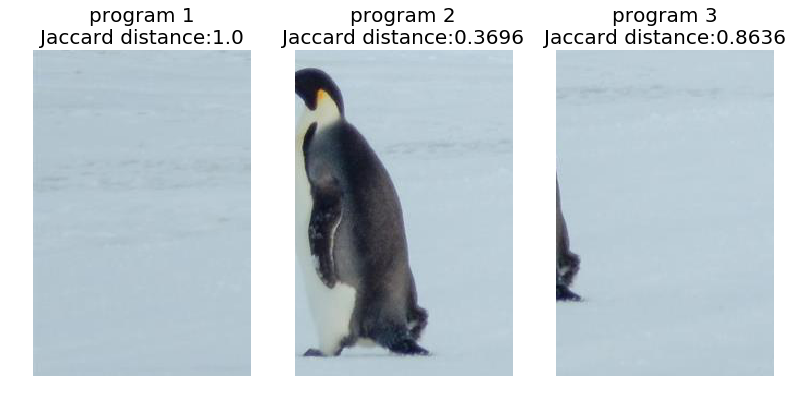

In [1026]:
fig =  plt.figure()

# the pixel boundaries would typically come from some kind of computer vision routine
x_start_p1 = 0; x_start_p2 = 390; x_start_p3 = 490
x_end_p1 = 200; x_end_p2 = 590; x_end_p3 = 690
y_start_p1 = 600; y_start_p2 = 610; y_start_p3 = 660
y_end_p1 = 900; y_end_p2 = 910; y_end_p3 = 960

box_program_1 = (x_start_p1, y_start_p1, x_end_p1, y_end_p1)
box_program_2 = (x_start_p2, y_start_p2, x_end_p2, y_end_p2)
box_program_3 = (x_start_p3, y_start_p3, x_end_p3, y_end_p3)

plot_num = 1
for program_name, bounding_box in zip(['program 1', 'program 2', 'program 3'],
                                      [box_program_1, box_program_2, box_program_3]):
    ax = fig.add_subplot(1, 3, plot_num)
    current_region = im.crop(bounding_box)
    current_region_bool_matrix = generate_bool_matrix(im, bounding_box[0], bounding_box[2],
                                                      bounding_box[1], bounding_box[3])
    jaccard_dist = jaccard(current_region_bool_matrix, reference_matrix)
    ax.set_title('{program}\nJaccard distance:{dist}'.format(program=program_name,
                                                             dist=np.around(jaccard_dist, 4)),
                                                      fontsize=20)
    ax.imshow(current_region)
    ax.axis('off')
    plot_num += 1

fig.subplots_adjust(wspace=0.01)
fig.set_size_inches(14,6)

So, larger Jaccard distances are farther away from the ground truth match. We've just used a relatively simple 1D `scipy.spatial.distance` function to assess the output of computer vision routines. In pratice, one would normally use the **Jaccard index**, $J_I = 1 - J_D$, such that the best match has the highest value & values $ > 0.5 $ are typically considered decent matches.  

## 4.3 Calculate the Yule distance (dissimilarity) between two 1D boolean arrays

It seems that these Boolean distance calculations have different strengths and weaknesses depending on the application domain. I haven't seen as many interesting examples with the Yule distance as with the last two, but let's see how it behaves for an example case anyway.

Let's consider a very crude way to compare a hand-written letter with computer-generated letters--looking at at the positions of 'dark pixels.'

im_handwritten_T.size: (225, 224)
im_handwritten_T.getbands: ('R', 'G', 'B')


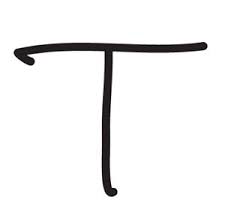

In [1027]:
im_handwritten_T = Image.open('hand_written_t.jpg')
print('im_handwritten_T.size:', im_handwritten_T.size)
print('im_handwritten_T.getbands:', im_handwritten_T.getbands())
im_handwritten_T

im_computer_T.size: (225, 224)
im_computer_T.getbands: ('R', 'G', 'B')


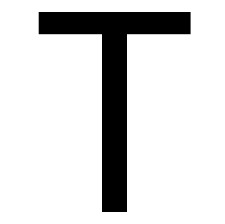

In [1028]:
im_computer_T = Image.open('computer_T.jpg')
print('im_computer_T.size:', im_computer_T.size)
print('im_computer_T.getbands:', im_computer_T.getbands())
im_computer_T

im_computer_S.size: (225, 224)
im_computer_S.getbands: ('R', 'G', 'B')


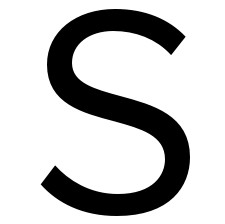

In [1029]:
im_computer_S = Image.open('computer_S.jpg')
print('im_computer_S.size:', im_computer_S.size)
print('im_computer_S.getbands:', im_computer_S.getbands())
im_computer_S

In [1030]:
handwritten_T_array = np.asarray(im_handwritten_T)
computer_T_array = np.asarray(im_computer_T)
computer_S_array = np.asarray(im_computer_S)
computer_S_array

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ..., 
       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ..., 
        [255, 255, 255],
        [255, 255, 255],
        [255, 255,

In [1031]:
# generate and compare boolean arrays based on pixel darkness
from scipy.spatial.distance import yule
hand_written_boolean = handwritten_T_array.ravel() < 250
for condition, pixel_array in zip(['computer S', 'computer T'], [computer_S_array, computer_T_array]):
    computer_boolean = pixel_array.ravel() < 250
    yule_dist = yule(computer_boolean, hand_written_boolean)
    print(condition, 'yule distance:', yule_dist)

computer S yule distance: 1.1003904599547838
computer T yule distance: 0.3105709587080567


The Yule dissimilarity is bounded by 0 and 2 for boolean data sets, and we can see that the hand written "T" is closer to the computer-generated "T", even using this crude measure. Far more sophisticated use of the Yule distance in handwriting recognition has been described in the literature--see, for example: Zhang and Srihari (2003) *Proceedings of SPIE-IS&T Electronic Imaging* **5010**.

# 5) Distances in Large Data Sets: Binary Space Partitioning

## 5.1) General Concept of Binary Space Partitioning (BSP)

The basic idea behind BSP is to split a space into a set of cells using so-called hyperplanes. In 3-D, this would mean using 2D planes to progressively divide the space into cells containing points, with the data structure typically organized in a "tree" that allows for i.e., rapid searching for nearest neighbors.

Some of the primary applications of BSP include:

 - 3D computer graphics
 - collision detection
 - robotics
 - ray tracing
 - video games

## 5.2) Simple Example of General BSP

# 6) Convex Hulls 

## 6.1 Convexity, Convex Hulls and General Position

**Convex Regions**: a region is convex if any two points of the region are visible to one another within the region. The **convex hull** is the smallest convex region containing the point set *S*.

**Convex Hull by Example -- Back to Kindergarden Geoboards**
![Geoboard](images/geoboard.jpg)

**Calculate it yourself with the incredibly-useful `scipy.spatial` library**

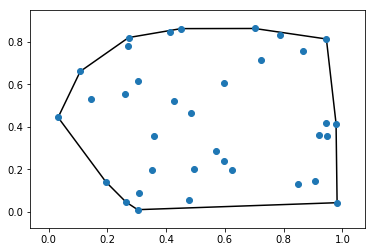

In [1032]:
#a simple example of the convex hull for a random set of points in the plane
random_2D_array = np.random.random_sample((35,2))
hull = scipy.spatial.ConvexHull(random_2D_array)
sample_hull_plot = scipy.spatial.convex_hull_plot_2d(hull)

Prerequisites: **General Position**

A set of points (or other geometric objects) are said to be in **general position** if they avoid troublesome configurations, known as *degenerate* situations. The precise definition of **general position** varies depending on the algorithm. A point set is always in general position if the n points are chosen randomly, but this is (of course) not the case with real world data.

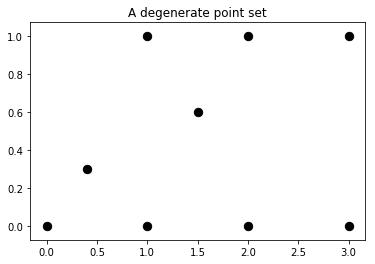

In [1033]:
#produce an example of a degenerate point set:
fig_degenerate = plt.figure()
degenerate_vertices = np.array([[0,0],
                                [1,0],
                                [2,0],
                                [3,0],
                                [3,1],
                                [2,1],
                                [1,1],
                                [1.5,0.6],
                                [0.4,0.3]])
ax = fig_degenerate.add_subplot(111)
ax.scatter(degenerate_vertices[...,0], degenerate_vertices[...,1], c='k', s=70)
ax.set_title('A degenerate point set')

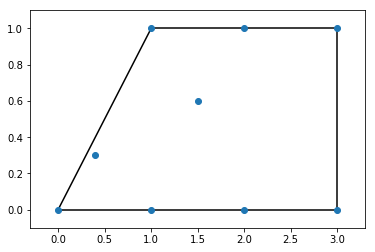

In [1034]:
#try calculating the convex hull of the above point set
hull = scipy.spatial.ConvexHull(degenerate_vertices, qhull_options='Qc')
plot = scipy.spatial.convex_hull_plot_2d(hull)

In [1035]:
hull.coplanar #the above computation is possible because Qhull is able to ignore a subset of the pathological input points (their indices and neighbour indices are only computed with the additional 'Qc' option sent to Qhull)

array([[2, 0, 3],
       [1, 0, 0],
       [5, 3, 6]], dtype=int32)

In this case the algorithm actually handles the potentially pathological collinear data, but it is important to note that this kind of data could typically cause issues.

## 6.2 Practical Algorithm Time & Space Complexities

Convex Hull algorithms are fundamental to computational geometry and it is useful to have a working knowledge of the terminology used to describe their performance.

Complexity analysis captures the speed of an algorithm as a function of data input size using *Big-Oh* notation.

For a specific algorithm and an input of size $n$, the running time is captured as $O(f(n))$, and $cf(n)$ is the upper bound on the running time of the algorithm, where $c>0$ is a constant. The upper bound means that we typically ignore lower values of $n$ and focus on the asymptotic 'worst-case' scenarios.

Selected Examples:

| big-Oh notation | name | Example | 
|-----------------|-------------|---|
|$O(1)$ | Constant | Adding two numbers
|$O(n \textrm{ log } n)$ | loglinear | Sorting a list
|$O(n^2)$ | Quadratic | Incremental convex hull algorithm
|$O(n^k)$ | Polynomial | Robot Arm Motion Planning
|$O(c^n)$ | Exponential | Some Brute Force Algorithms


We focus on **time complexity**, but there are also cases where memory usage (**space complexity**) is critical for an algorithm.

## 6.3 Determine the time complexity of the `ConvexHull` algorithm used by `scipy.spatial` (which is actually just a wrapper for the popular `qhull` package)

In [1036]:
#we will use an empirical approach, although an expert could study the algorithm / source code and identify the 'rate-limiting' step based on the type of operations performed

def linear(n, m, c):
    return m * n + c

def loglinear(n, m, c):
    return m * (n * np.log(n)) + c

def quadratic(n, m, c):
    return m * (n ** 2) + c

points_list = [1000,20000,30000,50000,70000,100000,200000,300000,500000,700000,900000,1000000]
list_times = []

for num_points in points_list:
    random_2D_points = np.random.random_sample((num_points,2))
    start_time = time.time()
    hull = scipy.spatial.ConvexHull(random_2D_points)
    elapsed_time = time.time() - start_time
    list_times.append(elapsed_time)
    print('benchmarked', num_points, 'points in:', elapsed_time, ' seconds')

benchmarked 1000 points in: 0.0011439323425292969  seconds
benchmarked 20000 points in: 0.004415988922119141  seconds
benchmarked 30000 points in: 0.012378931045532227  seconds
benchmarked 50000 points in: 0.021942138671875  seconds
benchmarked 70000 points in: 0.01394796371459961  seconds
benchmarked 100000 points in: 0.01789999008178711  seconds
benchmarked 200000 points in: 0.04222893714904785  seconds
benchmarked 300000 points in: 0.05702400207519531  seconds
benchmarked 500000 points in: 0.09153008460998535  seconds
benchmarked 700000 points in: 0.14367914199829102  seconds
benchmarked 900000 points in: 0.17280197143554688  seconds
benchmarked 1000000 points in: 0.1990671157836914  seconds


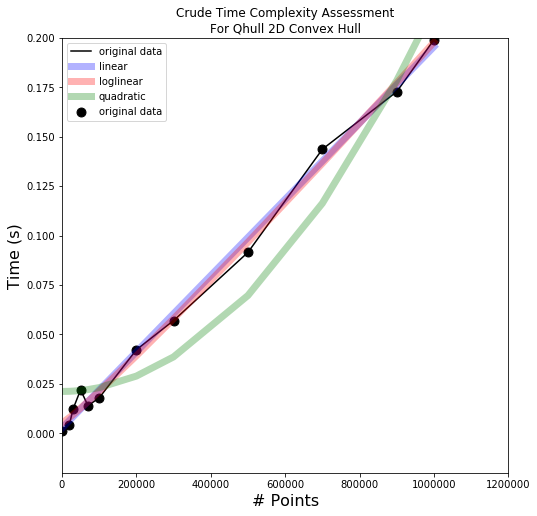

In [1037]:
popt, pcov = scipy.optimize.curve_fit(linear, points_list, list_times)
linear_y_data = linear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(loglinear, points_list, list_times)
loglinear_y_data = loglinear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(quadratic, points_list, list_times)
quadratic_y_data = quadratic(np.array(points_list), popt[0], popt[1])

fig_bench_hull = plt.figure()
ax = fig_bench_hull.add_subplot(111)
ax.scatter(points_list, list_times, c='k', label='original data', s = 80)
ax.plot(points_list, list_times, c='k', label='original data')

ax.plot(points_list, linear_y_data, c = 'blue', lw=7,alpha = 0.3, label = 'linear')
ax.plot(points_list, loglinear_y_data, c = 'red', lw=7,alpha = 0.3, label = 'loglinear')
ax.plot(points_list, quadratic_y_data, c = 'green', lw=7,alpha = 0.3, label = 'quadratic')
ax.legend(loc=2)

ax.set_title('Crude Time Complexity Assessment\nFor Qhull 2D Convex Hull')
ax.set_xlim(-50,1.2e+6)
ax.set_ylim(-0.02,0.20)
ax.set_xlabel('# Points',fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
fig_bench_hull.set_size_inches(8,8)


    

Qhull implements the Quickhull algorithm for convex hull [Barber et al. '96]. It has output-sensitive performance that can slightly improve on loglinear in some cases.

While the above Qhull algorithm is highly specialized / optimized and works well across several dimensions, a more straightforward summary of general Convex Hull algorithm performance is shown below:


Paradigm | 2D Complexity | 3D Complexity | Notes
---------|---------------|---------------|-------
Incremental | $O(n^2)$ | $O(n^2)$| often implemented because of conceptual simplicity
Gift-wrapping | $O(nh)$ | $O(nf)$| 
Graham scan | $O(n\:{\log}\:n)$ | N/A |
divide-and-conquer (recursion) | $O(n\:{\log}\:n)$ | $O(n\:{\log}\:n)$| 4D and up: $\Omega(n^{d/2})$





### 6.3.1 Can the Python community do better than `scipy.spatial.ConvexHull`?

**NO**, not from an algorithmic standpoint, because loglinear performance is the lower bound on sorting operations and we can reduce the convex hull problem (in the simplest case) to a sorting problem for a parabola:

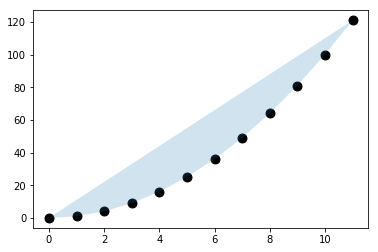

In [1038]:
x = np.arange(12)
y = x ** 2
fig_hull = plt.figure()
ax = fig_hull.add_subplot(111)
ax.scatter(x,y,s=80,c ='k')
closed_parabola = np.zeros((x.shape[0] + 1,2))
closed_parabola[:-1,0] = x
closed_parabola[:-1,1] = y
closed_parabola[:-1] = np.array(x[0],y[0])
parabola = np.array(list(zip(x,y)))
p = Polygon(parabola, alpha = 0.2)
ax.add_patch(p)


It turns out that, even if we didn't care about connectivity (i.e., only wanted the hull points without their order), the fastest possible performance is still loglinear. This was discovered relatively recently (1985) by Franco Preparata and Michael Shamos.

##  6.4 Practical Examples with `scipy.spatial.ConvexHull`

### 6.4.1 2D

Problem: Let's say you have a startup that built a long-distance robot that you'd like to send along land from the far West of Oregon to its Eastern Border. However, a sufficient number of Oregon residents have objected to this project such that a straight line through the State will not be possible. Instead, you decide to treat the entire area of Oregon as hazardous for the robot, planning to travel on the borders (or in the more permissive neibhouring States) only. Assuming flat terrain, find the minimum total distance that may be traveled by the robot from the Westernmost point of Oregon to its Easternmost point. 

In [1039]:
#determine the indices of the West / East limit points (which also fall on the convex hull, by definition):
with open('Oregon_vertices.p', 'rb') as input_data:
    Oregon_vertices = pickle.load(input_data)
x_min_index = np.argmin(Oregon_vertices[...,0])
x_max_index = np.argmax(Oregon_vertices[...,0])
x_min_index, x_max_index

(0, 137)

/Users/treddy/miniconda2/envs/mda_python35/lib/python3.5/site-packages/scipy/spatial/_plotutils.py:20: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()


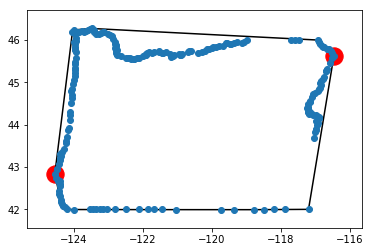

In [1040]:
#confirm positions of the West/ East limits in the context of the state and its convex hull
x_min_coord = Oregon_vertices[0]
x_max_coord = Oregon_vertices[137]
fig_Oregon_limits = plt.figure()
ax = fig_Oregon_limits.add_subplot(111)
ax.scatter(x_min_coord[0], x_min_coord[1], c='red', s = 300)
ax.scatter(x_max_coord[0], x_max_coord[1], c='red', s = 300)

hull = scipy.spatial.ConvexHull(Oregon_vertices)
hull_plot = scipy.spatial.convex_hull_plot_2d(hull, ax)

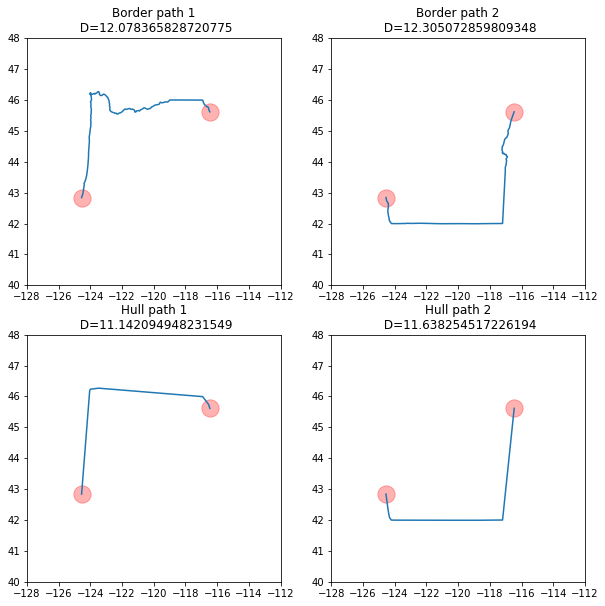

In [1041]:
#plot and assess travel distance for the 2 possible border paths and 2 possible Convex Hull paths:
fig_Oregon_paths = plt.figure()
fig_Oregon_paths.set_size_inches(10,10)

ax_border_1 = fig_Oregon_paths.add_subplot(221)
ax_border_1.plot(Oregon_vertices[:138, 0], Oregon_vertices[:138, 1])
dist_1 = np.diag(scipy.spatial.distance_matrix(Oregon_vertices[:137],Oregon_vertices[1:138])).sum()
ax_border_1.set_title('Border path 1\n D={dist}'.format(dist=dist_1))

ax_border_2 = fig_Oregon_paths.add_subplot(222)
cycled_array = np.concatenate((Oregon_vertices,np.array([Oregon_vertices[0,...]])))
ax_border_2.plot(cycled_array[137:, 0], cycled_array[137:, 1])
dist_2 = np.diag(scipy.spatial.distance_matrix(cycled_array[137:-1],cycled_array[138:])).sum()
ax_border_2.set_title('Border path 2\n D={dist}'.format(dist=dist_2))

#note: in 2D scipy returns hull coords in CCW order
hull_coords = hull.points[hull.vertices]
hull_min_index = np.argmin(hull_coords[...,0])
hull_max_index = np.argmax(hull_coords[...,0])
ax_border_3 = fig_Oregon_paths.add_subplot(223)
ax_border_3.plot(hull_coords[hull_max_index:hull_min_index + 1,0],hull_coords[hull_max_index:hull_min_index + 1,1])
dist_3 = np.diag(scipy.spatial.distance_matrix(hull_coords[hull_max_index:hull_min_index],hull_coords[hull_max_index + 1:hull_min_index + 1])).sum()
ax_border_3.set_title('Hull path 1\n D={dist}'.format(dist=dist_3))

ax_border_4 = fig_Oregon_paths.add_subplot(224)
cycled_hull_coords = np.concatenate((hull_coords,hull_coords))
ax_border_4.plot(cycled_hull_coords[hull_min_index:hull_coords.shape[0] + 2,0], cycled_hull_coords[hull_min_index:hull_coords.shape[0] + 2,1])
dist_4 = np.diag(scipy.spatial.distance_matrix(cycled_hull_coords[hull_min_index:hull_coords.shape[0] + 1],cycled_hull_coords[hull_min_index + 1:hull_coords.shape[0] + 2])).sum()
ax_border_4.set_title('Hull path 2\n D={dist}'.format(dist=dist_4))

for axis in [ax_border_1, ax_border_2, ax_border_3,ax_border_4]:
    axis.scatter(x_min_coord[0], x_min_coord[1], c='red', s = 300, alpha = 0.3)
    axis.scatter(x_max_coord[0], x_max_coord[1], c='red', s = 300, alpha = 0.3)
    axis.set_xlim(-128,-112)
    axis.set_ylim(40,48)

So, clockwise Hull Path 1 is the shortest.

### 6.4.2 3D

Problem: Estimate the surface area of a spherical influenza A virus based on my simulation coordinates.

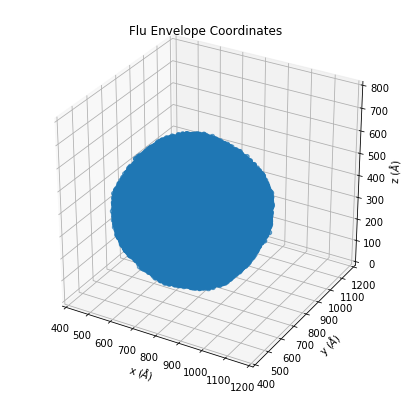

In [1042]:
#load and plot the data:
fig_flu = plt.figure()
fig_flu.set_size_inches(7,7)
flu_coords = pickle.load(open('flu_coords.p','rb'), encoding='latin1') # was pickled in py2, so encoding issues
ax = fig_flu.add_subplot(111,projection = '3d')
ax.scatter(flu_coords[...,0], flu_coords[...,1], flu_coords[...,2])
ax.set_xlabel('x ($\AA$)')
ax.set_ylabel('y ($\AA$)')
ax.set_zlabel('z ($\AA$)')
ax.set_xlim3d(400,1200)
ax.set_ylim3d(400,1200)
ax.set_zlim3d(0,800)
ax.set_title('Flu Envelope Coordinates')

(1404, 3, 3)
surface area estimate from Convex Hull: 1103521.4229953205
surface area of roughly equivalent sphere: 1134557.42184
% reconstitution of sphere: 97.2644840849


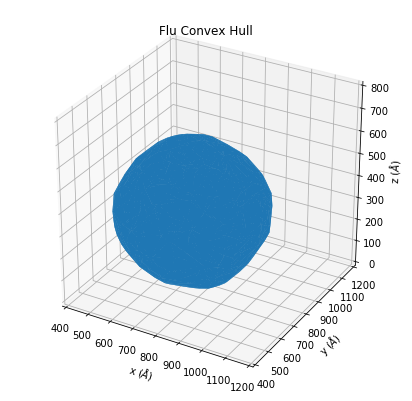

In [1043]:
#calculate the 3D convex hull, plot the facets (triangles) of the hull, and sum together their areas to estimate the overall area of the viral surface
fig_flu_hull = plt.figure()
ax = fig_flu_hull.add_subplot(111, projection = '3d')
flu_hull = scipy.spatial.ConvexHull(flu_coords)
hull_triangle_coords = flu_hull.points[flu_hull.simplices]
flu_triangles = Poly3DCollection(hull_triangle_coords, alpha = 0.1)
ax.add_collection3d(flu_triangles)
ax.set_xlabel('x ($\AA$)')
ax.set_ylabel('y ($\AA$)')
ax.set_zlabel('z ($\AA$)')
ax.set_xlim3d(400,1200)
ax.set_ylim3d(400,1200)
ax.set_zlim3d(0,800)
fig_flu_hull.set_size_inches(7,7)
ax.set_title('Flu Convex Hull')

print(hull_triangle_coords.shape)
print('surface area estimate from Convex Hull:', flu_hull.area)

#compare again surface area of roughly equivalent sphere
crude_radius = (flu_coords[...,2].max() - flu_coords[...,2].min()) / 2.
sphere_SA = 4. * math.pi * (crude_radius ** 2)
print('surface area of roughly equivalent sphere:', sphere_SA)
print('% reconstitution of sphere:', flu_hull.area / sphere_SA * 100)

Considering that flu isn't a perfect sphere, that % reconstitution of SA is an excellent indication that the calcluation was an excellent estimate.

# 7) Delaunay Triangulations

## 7.1 Definition and Basic Information

Named after Boris Delaunay (Russian Mathematician)

A **Delaunay Triangulation** is a triangulation that only has **legal edges**--edges that avoid small angles in triangles. The lexicographically sorted comparison of the full set of angles in two triangulations will always have larger angles for the Delaunay triangulation (other triangulations will have a smaller angle first).

General Position for Delaunay in 2D: no four points are cocircular

Textbook example of terrain reconstruction sensitivity to triangulation:
![terrain_Delaunay](images/terrain_reconstruction.jpg)

It is actually possible to construct a 2D Delaunay triangulation starting from any arbitrary triangulation by flipping one edge at a time (progressive illegal to legal edge flips), although this algorithm is slow ($O(n^2)$) and cannot be extended to 3D cases.

## 7.2 The Empty Circle Property

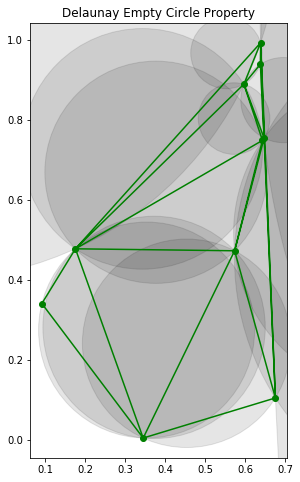

In [1044]:
#none of the original data points in S can fall within the circumcircle of a triangle for a Delaunay triangulation (alternative and very important definition)
#demonstration using scipy.spatial once again:
fig_Delaunay_circles = plt.figure()
fig_Delaunay_circles.set_size_inches(8,8)
ax = fig_Delaunay_circles.add_subplot(111, aspect='equal')
random_points = np.random.random_sample((10,2))
tri = scipy.spatial.Delaunay(random_points)
ax.triplot(random_points[...,0], random_points[...,1], tri.simplices, 'go-')

#deal with calculating and plotting the circumcircles
circumcenters, circumradii = circumcircle.calc_circumcircle(tri.points[tri.simplices])
patches = []
for circumcenter_coordinates, circumradius in zip(circumcenters,circumradii):
    patches.append(matplotlib.patches.Circle((circumcenter_coordinates[0],circumcenter_coordinates[1]),circumradius[0],fill=False, alpha=1.0, fc='none', ec='none',))
p = PatchCollection(patches, alpha=0.1,match_original = True)
ax.add_collection(p)

ax.set_title('Delaunay Empty Circle Property')

Also note that connecting the circumcenters of the circumcircles would produce the Voronoi diagram (they are dual graphs) -- this can be a very useful property and indeed Delaunay was a student of Voronoi.

## 7.3 Practical Applications of scipy.spatial.Delaunay()

##### 2D

Problem: You're building a network with prohibitively expensive wiring but as long as there is a path from one computer to another the network will function properly. Given a set of 25 computers (nodes) with fixed positions (i.e., in an office), find the minimum amount of wiring and the appropriate connectivity for the network. The key here is to exploit the fact that the Euclidean minimum spanning tree (EMST) is a subgraph of the Delaunay triangulation of the point set.

diagonal of undirected_graph: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


NameError: name 'itertools' is not defined

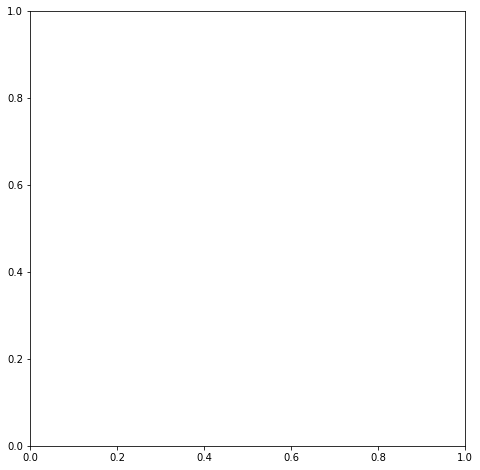

In [1045]:

computer_positions = np.random.random_sample((25,2))
tri = scipy.spatial.Delaunay(computer_positions)
#need undirected graph data in a format ready for scipy.sparse.csgraph.minimum_spanning_tree
#this will be an NxN symmetric matrix with Euclidean distances for direct connections in the triangulation, and 0 for "self" and other points that are not connected

#so we effectively want a special distance matrix, which means we need to know which points are connected, so we will likely have to use the simplices attribute of tri

triangle_indices = tri.simplices #has shape (n_triangles, 3)

#iterate through the triangle indices and populate a template distance matrix (default 0 for no connection)
undirected_graph = np.zeros((25,25))

for triangle_index_array in triangle_indices:
    equivalent_coordinate_array = tri.points[triangle_index_array]
    distance_array = scipy.spatial.distance.pdist(equivalent_coordinate_array)
    undirected_graph[triangle_index_array[0],triangle_index_array[1]] = distance_array[0]
    undirected_graph[triangle_index_array[0],triangle_index_array[2]] = distance_array[1]
    undirected_graph[triangle_index_array[1],triangle_index_array[2]] = distance_array[2]

#sanity check: no point should be connected to itself (all diagonal values zero)
print('diagonal of undirected_graph:', np.diag(undirected_graph))

sparse_result = scipy.sparse.csgraph.minimum_spanning_tree(undirected_graph)

#iterate through sparse matrix, plotting and adding up distances
fig_emst = plt.figure()
fig_emst.set_size_inches(8,8)
ax = fig_emst.add_subplot(111,aspect='equal')

cx = sparse_result.tocoo() #convert to coordinate representation of matrix
label = 0
total_distance = 0
for i,j,v in itertools.izip(cx.row, cx.col, cx.data):
    if v != 0: #there's an edge if nonzero
        p1 = computer_positions[i]
        p2 = computer_positions[j]
        total_distance += v
        if not label:
            ax.plot([p1[0],p2[0]],[p1[1],p2[1]],c='green',ls='-',marker='o', label = 'EMST', alpha = 0.2, lw =12)
            label += 1
        else: 
            ax.plot([p1[0],p2[0]],[p1[1],p2[1]],c='green',ls='-',marker='o', alpha = 0.2, lw = 12)
ax.legend()
ax.set_title('EMST (D = {dist}) as subgraph of Delaunay Triangulation'.format(dist=total_distance))

#overlay the original triangulation for comparison
ax.triplot(computer_positions[...,0], computer_positions[...,1], triangle_indices, c = 'k',marker = 'o')


##  7.4 Measuring the time complexity of `scipy.spatial.Delaunay()`

In [ ]:
#use a similar empirical approach to that used above for benchmarking the convex hull code

points_list = [1000,20000,30000,50000,70000,100000,200000,300000,500000,700000,900000,1000000]
list_times = []

for num_points in points_list:
    random_2D_points = np.random.random_sample((num_points,2))
    start_time = time.time()
    tri = scipy.spatial.Delaunay(random_2D_points)
    elapsed_time = time.time() - start_time
    list_times.append(elapsed_time)
    print('benchmarked', num_points, 'points in:', elapsed_time, ' seconds')

In [ ]:
    
popt, pcov = scipy.optimize.curve_fit(linear, points_list, list_times)
linear_y_data = linear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(loglinear, points_list, list_times)
loglinear_y_data = loglinear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(quadratic, points_list, list_times)
quadratic_y_data = quadratic(np.array(points_list), popt[0], popt[1])

fig_bench_Delaunay = plt.figure()
ax = fig_bench_Delaunay.add_subplot(111)
ax.scatter(points_list, list_times, c='k', label='original data', s = 80)
ax.plot(points_list, list_times, c='k', label='original data')

ax.plot(points_list, linear_y_data, c = 'blue', lw=7,alpha = 0.3, label = 'linear')
ax.plot(points_list, loglinear_y_data, c = 'red', lw=7,alpha = 0.3, label = 'loglinear')
ax.plot(points_list, quadratic_y_data, c = 'green', lw=7,alpha = 0.3, label = 'quadratic')
ax.legend(loc=2)

ax.set_title('Crude Time Complexity Assessment\nFor Qhull 2D Delaunay Triangulation')
#ax.set_xlim(-50,1.2e+6)
#ax.set_ylim(-0.02,0.20)
ax.set_xlabel('# Points',fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
fig_bench_Delaunay.set_size_inches(8,8)

So, `scipy.spatial.Delaunay` appears to have loglinear performance, which is the optimum.

# 8) Voronoi Diagrams

###  5.1 Definition and Importance

They were first seriously studied by Georgy Voronoi in 1908, but are also known as Thiessen polygons and Dirichlet tessellations.

A Voronoi diagram defines Voronoi regions around each of the points in the original data set. The Voronoi region for a given point represents the portion of space in which all points not in the input data are closer to that point than to any other.

From a more practical standpoint, if you imagine a data set with all the grocery stores in your city as input points (generators), each grocery store will have its own Voronoi region, where all homes are closer to that grocery store than to any other. Applications span geography, marketing, network coverage, biology, robot motion planning, etc.

Crucially, the Voronoi diagram is the mathematical dual of the Delaunay Triangulation.

*All Voronoi regions (i.e., polygons in 2D) are convex.* This can be proven (although I won't do it!).

**General position in 2D**: no four generators are cocircular

### 5.2 Overview of Algorithms and their Time Complexities (2D)


Authors | Year | Citations | Paradigm | Performance
--------|------|-----------|----------|------------
Shamos and Hoey | 1975 | 1101 | divide-and-conquer | $O(n\:{\log}\:n)$
Green and Sibson | 1978 | 861 | incremental | $O(n^2)$
Guibas and Stolfi | 1985 | 1506 | quad-edge data structure | $O(n\:{\log}\:n)$
Fortune | 1987 | 1402 | sweepline | $O(n\:{\log}\:n)$

Loglinear performance is known to be optimal.

### 5.3 Practical Problem Solving with `scipy.spatial.Voronoi()`

#### 2D

**Problem**: Determine which residential locations are closest to a given water pump during the cholera outbreak in London ~150 years ago. This is the classic John Snow example with modern mapping data obtained from Robin Wilson (see below). The sizes of the red points are proportional to the number of fatalities reported at that residential location.

In [ ]:
#load data modified from Robin Wilson's (University of Southampton) blog
array_pump_coords = pickle.load(open('array_pump_data.p','rb')) 
array_cholera_data = pickle.load(open('array_cholera_data.p','rb')) 

#plot
figure_voronoi = plt.figure()
figure_voronoi.set_size_inches(8,8)
ax = figure_voronoi.add_subplot('111', aspect='equal')
vor = scipy.spatial.Voronoi(array_pump_coords)
voronoi_figure = scipy.spatial.voronoi_plot_2d(vor, ax = ax)
ax.scatter(array_cholera_data[...,0], array_cholera_data[...,1], s = array_cholera_data[...,2] * 8, c = 'red', edgecolor='none') #scale scatter point area by number of fatalities
ax.scatter(array_pump_coords[...,0], array_pump_coords[...,1], s = 60, c = 'blue', edgecolor='none') #default pump sizes a bit too small


#### 3D

**Problem**: You're designing an autonomous drone that will fly in an urban location and will have to avoid obstacles that are both stationary (i.e., tall buildings) and dynamic (helicopter traffic, etc.). Demonstrate an approach to determining the safest routes (i.e., farthest from obstacles) for the drone in 3D space. Assume that using a random set of 3D points is a suitable simulation of the kinds of coordinate data the drone will receive in real time. 

In [ ]:
air_traffic_mess = np.random.random_sample((50,3))
#the edges of a 3D Voronoi diagram will be the farthest from the obstacle coordinates
vor = scipy.spatial.Voronoi(air_traffic_mess)
        
fig_drone_3d = plt.figure()
fig_drone_3d.set_size_inches(8,8)
ax = fig_drone_3d.add_subplot(111, projection = '3d')

for ridge_indices in vor.ridge_vertices:
    voronoi_ridge_coords = vor.vertices[ridge_indices]
    ax.plot(voronoi_ridge_coords[...,0], voronoi_ridge_coords[...,1], voronoi_ridge_coords[...,2], lw=2, c = 'green', alpha = 0.05)
    
vor_vertex_coords = vor.vertices

ax.scatter(air_traffic_mess[...,0], air_traffic_mess[...,1], air_traffic_mess[...,2], c= 'k', label='obstacles', edgecolor='none')
ax.scatter(vor_vertex_coords[...,0], vor_vertex_coords[...,1], vor_vertex_coords[...,2], c= 'orange', label='Voronoi vertices',edgecolors='white', marker = 'o', alpha = 0.9)

ax.legend()
ax.set_xlim3d(air_traffic_mess[...,0].min(), air_traffic_mess[...,0].max())
ax.set_ylim3d(air_traffic_mess[...,1].min(), air_traffic_mess[...,1].max())
ax.set_zlim3d(air_traffic_mess[...,2].min(), air_traffic_mess[...,2].max())

We would want the drone to follow the green lines, although the data still needs to be cleaned up a bit. For example, we'd like to deal with the "edges at infinity" (outside the Voronoi diagram, usually denoted as "-1" in the data structures returned by scipy/ qhull) more gracefully.

At the moment it appears to be non-trivial to plot the polyhedra around each of the obstacles. This is probably because the points need to be in the correct order for each polyhedron and again because of the edges at infinity. 

A nice take-home exercise would be to attempt to clean this data up and produce a really nice 3D Voronoi diagram.

### 5.4 Measuring the Time Complexity for 2D `scipy.spatial.Voronoi()`

In [ ]:
#use a similar empirical approach to that used above for benchmarking the convex hull code

points_list = [1000,20000,30000,50000,70000,100000,200000,300000,500000,700000,900000,1000000]
list_times = []

for num_points in points_list:
    random_2D_points = np.random.random_sample((num_points,2))
    start_time = time.time()
    tri = scipy.spatial.Voronoi(random_2D_points)
    elapsed_time = time.time() - start_time
    list_times.append(elapsed_time)
    print 'benchmarked', num_points, 'points in:', elapsed_time, ' seconds'

In [ ]:
popt, pcov = scipy.optimize.curve_fit(linear, points_list, list_times)
linear_y_data = linear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(loglinear, points_list, list_times)
loglinear_y_data = loglinear(np.array(points_list), popt[0], popt[1])
popt, pcov = scipy.optimize.curve_fit(quadratic, points_list, list_times)
quadratic_y_data = quadratic(np.array(points_list), popt[0], popt[1])

fig_bench_Voronoi = plt.figure()
ax = fig_bench_Voronoi.add_subplot(111)
ax.scatter(points_list, list_times, c='k', label='original data', s = 80)
ax.plot(points_list, list_times, c='k', label='original data')

ax.plot(points_list, linear_y_data, c = 'blue', lw=7,alpha = 0.3, label = 'linear')
ax.plot(points_list, loglinear_y_data, c = 'red', lw=7,alpha = 0.3, label = 'loglinear')
ax.plot(points_list, quadratic_y_data, c = 'green', lw=7,alpha = 0.3, label = 'quadratic')
ax.legend(loc=2)

ax.set_title('Crude Time Complexity Assessment\nFor Qhull 2D Voronoi Diagram')
#ax.set_xlim(-50,1.2e+6)
#ax.set_ylim(-0.02,0.20)
ax.set_xlabel('# Points',fontsize=16)
ax.set_ylabel('Time (s)', fontsize=16)
fig_bench_Voronoi.set_size_inches(8,8)

The loglinear performance is known to be optimal so we can't really improve on this from an algorithmic standpoint.

#### 6.1.1 `scipy.spatial.SphericalVoronoi()` 

Nikolai Nowaczyk and I worked on this PR (https://github.com/scipy/scipy/pull/5232) for quite some time but it was eventually merged in and should be available in scipy 0.18, which probably won't be out for quite some time. You could, however, compile scipy from the master branch to use it if you need it.

Specific applications include my work on spherical viruses, geography, astrophysics, MRI analysis, and any other field that deals with roughly spherical objects. A concise example follows below. **Note that this algorithm has quadratic time complexity, but loglinear is optimal**--so this is an opportunity for improvement within the Python community. That said, many of the better-performing algorithms appear challenging to implement (I tried one of them for a few months without much luck).

In [ ]:
#simple example for usage of scipy.spatial.SphericalVoronoi using random points on the surface of a sphere (but could easily imagine these points representing i.e., airports or cities on the surface of the earth, etc.)

num_points = 600

def marsaglia(num_points):
    '''generate random points on surface of sphere using Marsaglia's method (see: http://mathworld.wolfram.com/SpherePointPicking.html)'''
    x1 = np.random.uniform(low=-1.0, high=1.0,size=num_points)
    x2 = np.random.uniform(low=-1.0, high=1.0,size=num_points)

    #filter out points for which the sum of squares between the two distribution is >= 1
    mask = np.where(x1 ** 2 + x2 ** 2 < 1)
    x1 = x1[mask]
    x2 = x2[mask]

    x_coords = 2 * x1 * np.sqrt(1 - x1 ** 2 - x2 ** 2)
    y_coords = 2 * x2 * np.sqrt(1 - x1 ** 2 - x2 ** 2)
    z_coords = 1 - 2 * (x1 ** 2 + x2 ** 2)
    return np.stack((x_coords,y_coords,z_coords), axis=-1) 

points = marsaglia(num_points=num_points)

fig_spherical_Voronoi = plt.figure()
fig_spherical_Voronoi.set_size_inches(16,8)
ax1 = fig_spherical_Voronoi.add_subplot(121, projection = '3d')
ax1.scatter(points[...,0], points[...,1], points[...,2],c='blue')
ax1.set_title('Random Points on Sphere')

ax2 = fig_spherical_Voronoi.add_subplot(122, projection = '3d')
#calculate the Voronoi diagram on the surface of the sphere and plot the Voronoi region polygons
sv = scipy.spatial.SphericalVoronoi(points, radius=1)
sv.sort_vertices_of_regions() #generally needed for plotting / SA calculation

for region in sv.regions:
    random_color = colors.rgb2hex(np.random.rand(3))
    polygon = Poly3DCollection([sv.vertices[region]], alpha=1.0)
    polygon.set_color(random_color)
    ax2.add_collection3d(polygon)
    
ax2.set_title('Voronoi Regions')

for axis in [ax1,ax2]:
    axis.set_xlim(-1.5,1.5)
    axis.set_ylim(-1.5,1.5)
    axis.set_zlim(-1.5,1.5)

#### 6.1.2 Calculating Surface Area of Spherical Polygons

Not only have I had to perform this calculation extensively in my own work on viruses, but I frequently get emails from geographers and MRI scientists asking about this calculation for polygons on the surface of a sphere. I recently wrote a proposal (https://github.com/scipy/scipy/issues/6069) to incorporate calculations of this nature into scipy. The best code I have for doing this at the moment was improved by Edd Edmondson (University of Portsmouth). Let's see if we get a sensible result from the sum of the surface areas of all polygons in the above example.

In [ ]:
#draft of code to calculate spherical polygon surface area
def convert_cartesian_array_to_spherical_array(coord_array,angle_measure='radians'):
    '''Take shape (N,3) cartesian coord_array and return an array of the same shape in spherical polar form (r, theta, phi). Based on StackOverflow response: http://stackoverflow.com/a/4116899
    use radians for the angles by default, degrees if angle_measure == 'degrees' '''
    spherical_coord_array = np.zeros(coord_array.shape)
    xy = coord_array[...,0]**2 + coord_array[...,1]**2
    spherical_coord_array[...,0] = np.sqrt(xy + coord_array[...,2]**2)
    spherical_coord_array[...,1] = np.arctan2(coord_array[...,1], coord_array[...,0])
    spherical_coord_array[...,2] = np.arccos(coord_array[...,2] / spherical_coord_array[...,0])
    if angle_measure == 'degrees':
        spherical_coord_array[...,1] = np.degrees(spherical_coord_array[...,1])
        spherical_coord_array[...,2] = np.degrees(spherical_coord_array[...,2])
    return spherical_coord_array

def convert_spherical_array_to_cartesian_array(spherical_coord_array,angle_measure='radians'):
    '''Take shape (N,3) spherical_coord_array (r,theta,phi) and return an array of the same shape in cartesian coordinate form (x,y,z). Based on the equations provided at: http://en.wikipedia.org/wiki/List_of_common_coordinate_transformations#From_spherical_coordinates
    use radians for the angles by default, degrees if angle_measure == 'degrees' '''
    cartesian_coord_array = np.zeros(spherical_coord_array.shape)
    #convert to radians if degrees are used in input (prior to Cartesian conversion process)
    if angle_measure == 'degrees':
        spherical_coord_array[...,1] = np.deg2rad(spherical_coord_array[...,1])
        spherical_coord_array[...,2] = np.deg2rad(spherical_coord_array[...,2])
    #now the conversion to Cartesian coords
    cartesian_coord_array[...,0] = spherical_coord_array[...,0] * np.cos(spherical_coord_array[...,1]) * np.sin(spherical_coord_array[...,2])
    cartesian_coord_array[...,1] = spherical_coord_array[...,0] * np.sin(spherical_coord_array[...,1]) * np.sin(spherical_coord_array[...,2])
    cartesian_coord_array[...,2] = spherical_coord_array[...,0] * np.cos(spherical_coord_array[...,2])
    return cartesian_coord_array

def calculate_haversine_distance_between_spherical_points(cartesian_array_1,cartesian_array_2,sphere_radius):
    '''Calculate the haversine-based distance between two points on the surface of a sphere. Should be more accurate than the arc cosine strategy. See, for example: http://en.wikipedia.org/wiki/Haversine_formula'''
    spherical_array_1 = convert_cartesian_array_to_spherical_array(cartesian_array_1)
    spherical_array_2 = convert_cartesian_array_to_spherical_array(cartesian_array_2)
    lambda_1 = spherical_array_1[1]
    lambda_2 = spherical_array_2[1]
    phi_1 = spherical_array_1[2]
    phi_2 = spherical_array_2[2]
    #we rewrite the standard Haversine slightly as long/lat is not the same as spherical coordinates - phi differs by pi/4
    spherical_distance = 2.0 * sphere_radius * math.asin(math.sqrt( ((1 - math.cos(phi_2-phi_1))/2.) + math.sin(phi_1) * math.sin(phi_2) * ( (1 - math.cos(lambda_2-lambda_1))/2.)  ))
    return spherical_distance

def calculate_surface_area_of_a_spherical_Voronoi_polygon(array_ordered_Voronoi_polygon_vertices,sphere_radius):
    '''Calculate the surface area of a polygon on the surface of a sphere. Based on equation provided here: http://mathworld.wolfram.com/LHuiliersTheorem.html
    Decompose into triangles, calculate excess for each'''
    #have to convert to unit sphere before applying the formula
    spherical_coordinates = convert_cartesian_array_to_spherical_array(array_ordered_Voronoi_polygon_vertices)
    spherical_coordinates[...,0] = 1.0
    array_ordered_Voronoi_polygon_vertices = convert_spherical_array_to_cartesian_array(spherical_coordinates)
    n = array_ordered_Voronoi_polygon_vertices.shape[0]
    #point we start from
    root_point = array_ordered_Voronoi_polygon_vertices[0]
    totalexcess = 0
    #loop from 1 to n-2, with point 2 to n-1 as other vertex of triangle
    # this could definitely be written more nicely
    b_point = array_ordered_Voronoi_polygon_vertices[1]
    root_b_dist = calculate_haversine_distance_between_spherical_points(root_point, b_point, 1.0)
    for i in 1 + np.arange(n - 2):
        a_point = b_point
        b_point = array_ordered_Voronoi_polygon_vertices[i+1]
        root_a_dist = root_b_dist
        root_b_dist = calculate_haversine_distance_between_spherical_points(root_point, b_point, 1.0)
        a_b_dist = calculate_haversine_distance_between_spherical_points(a_point, b_point, 1.0)
        s = (root_a_dist + root_b_dist + a_b_dist) / 2.
        totalexcess += 4 * math.atan(math.sqrt( math.tan(0.5 * s) * math.tan(0.5 * (s-root_a_dist)) * math.tan(0.5 * (s-root_b_dist)) * math.tan(0.5 * (s-a_b_dist))))
    return totalexcess * (sphere_radius ** 2)

In [ ]:
#sum the polygon areas from above and compare with theoretical surface area of unit sphere
calculated_SA = 0
for region in sv.regions:
    SA = calculate_surface_area_of_a_spherical_Voronoi_polygon(sv.vertices[region], 1.0)
    calculated_SA += SA
    
print 'calculated_SA:', calculated_SA
print 'theoretical SA:', 4 * math.pi

Well, that certainly looks like a sensible result! However, as you would be able to see in the above proposal, there are probably a few mysteries left to solve (if only to determine the range of pathological inputs). Also, what if we wanted to avoid a python for loop? Can we vectorize this code in numpy ufunc style if each polygon can have a different shape? Usually ufuncs operate on 'rectangular' arrays.